# Spectral analysis

## Loading of the spectral data and references

In [5]:
import numpy as np

kiwi_spectra = np.loadtxt("results/kiwi_avg_spectra.csv", delimiter=",")
reference_values = np.loadtxt("data/reference.csv", delimiter=",")
reference_values = reference_values[:180, :]
reference_values.shape

(180, 2)

## Outliers removal (unsupervised, PCA)

/tmp/ipykernel_8041/3681728974.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')


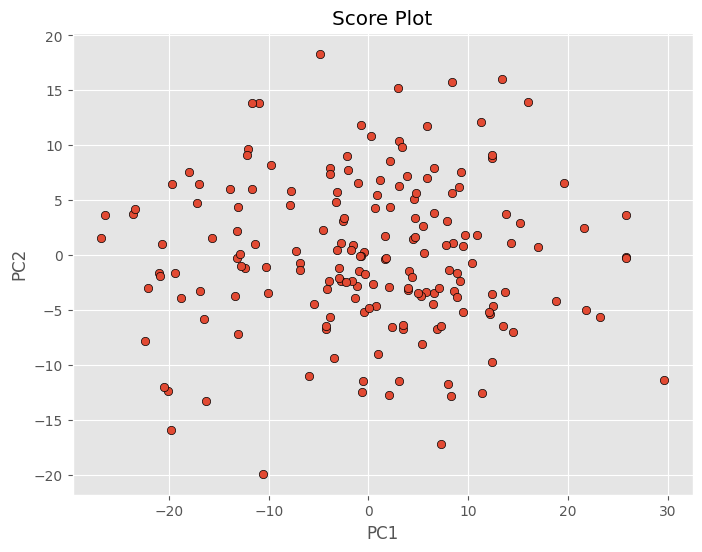

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
 
# Define the PCA object
pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(kiwi_spectra))
 
# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

Outlier removal from references

In [7]:
from sklearn.covariance import MinCovDet
 
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet(random_state=42).fit(T[:,:5])
 
# Get the Mahalanobis distance
malanobis = robust_cov.mahalanobis(T[:,:5])

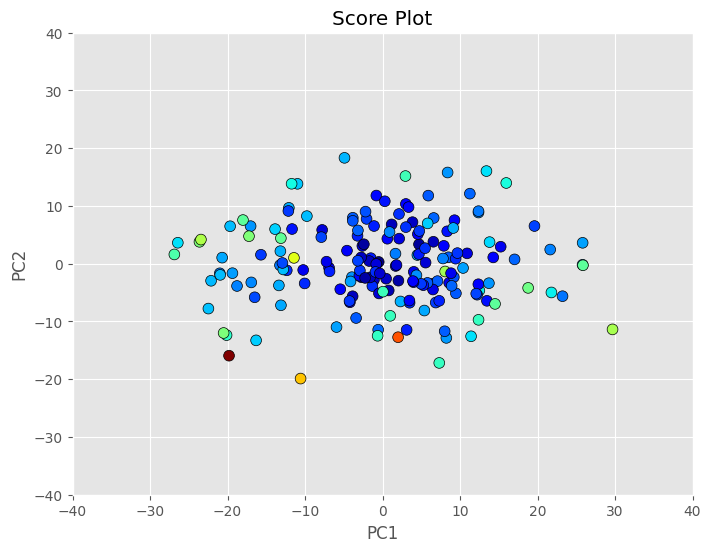

In [8]:
colors = [plt.cm.jet(float(i)/max(malanobis)) for i in malanobis]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim((-40, 40))
    plt.ylim((-40, 40))
    plt.title('Score Plot')
plt.show()

In [9]:
T.shape

(180, 180)

In [10]:
# Compute the 95th percentile value
threshold = np.percentile(malanobis, 95)

# Count how many entries are greater than this threshold
count = np.sum(malanobis > threshold)

print("Number of entries greater than 95% of the values:", count)

Number of entries greater than 95% of the values: 9


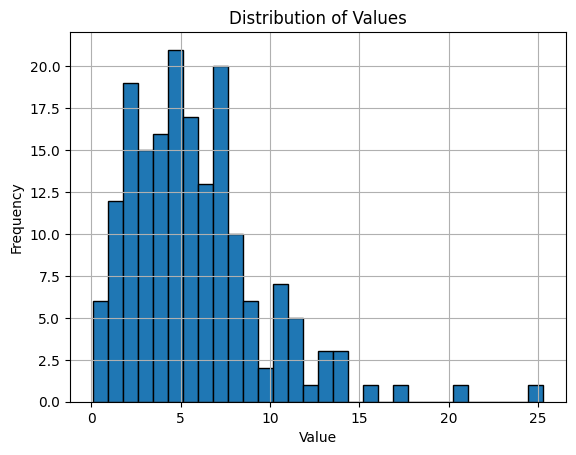

In [11]:
# Plot histogram
plt.hist(malanobis, bins=30, edgecolor='black')  # adjust bins as needed
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Outlier removal from spectra

/tmp/ipykernel_8041/869921937.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')


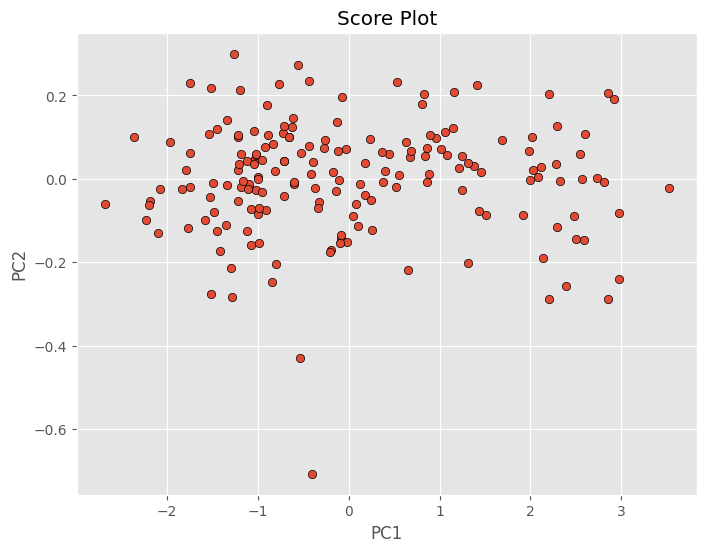

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
 
# Define the PCA object
pca = PCA()
 
# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(reference_values))
 
# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

In [13]:
T.shape

(180, 2)

In [14]:
# Compute the 95th percentile value
threshold = np.percentile(malanobis, 95)

# Count how many entries are greater than this threshold
count = np.sum(malanobis > threshold)

print("Number of entries greater than 95% of the values:", count)

Number of entries greater than 95% of the values: 9


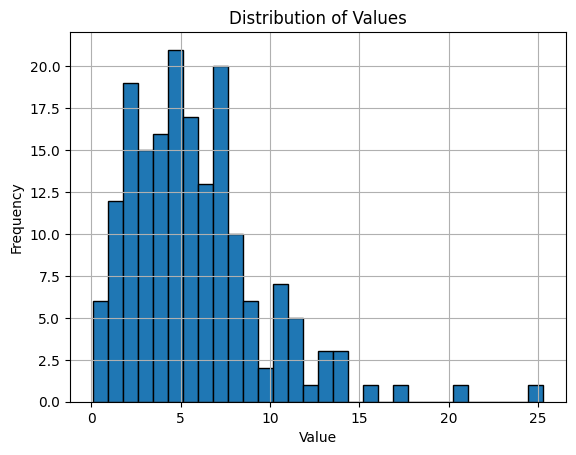

In [15]:
# Plot histogram
plt.hist(malanobis, bins=30, edgecolor='black')  
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

I think that point with value above 50 is probably an outlier, for the spectral data i'm not so sure.. Also what orientation should it be? all dots above some percentile?

## Pre-processing of data

### Smoothing

In [16]:
from scipy.signal import savgol_filter
 
X = kiwi_spectra[0, :]
wl = np.loadtxt("results/wavelengths.csv", delimiter=",")

w = 5
p = 2
X_smooth_1 = savgol_filter(X, w, polyorder = p, deriv=0)

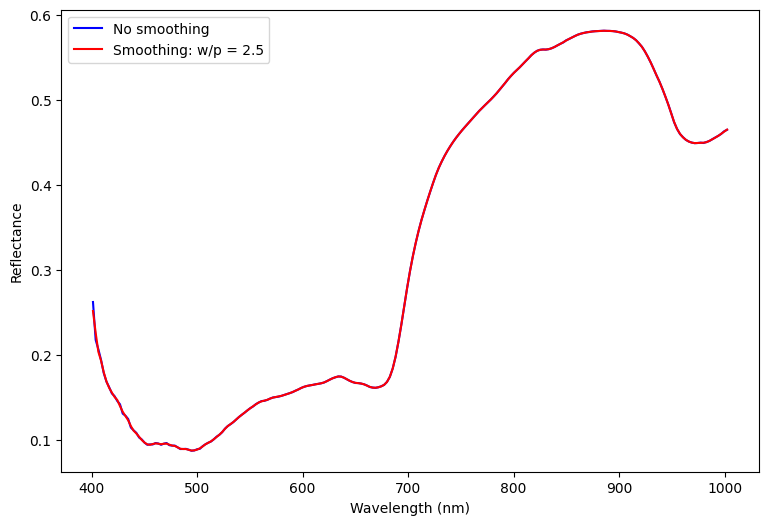

In [17]:
plt.figure(figsize=(9,6))
interval = np.arange(1,224,1)
plt.plot(wl[interval], X[interval], 'b', label = 'No smoothing')
plt.plot(wl[interval], X_smooth_1[interval], 'r', label = 'Smoothing: w/p = 2.5')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.show()

It does look quite smooth already, probably because of averaging?

## Scatter correction

In [18]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [19]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
 
    return (data_msc, ref)

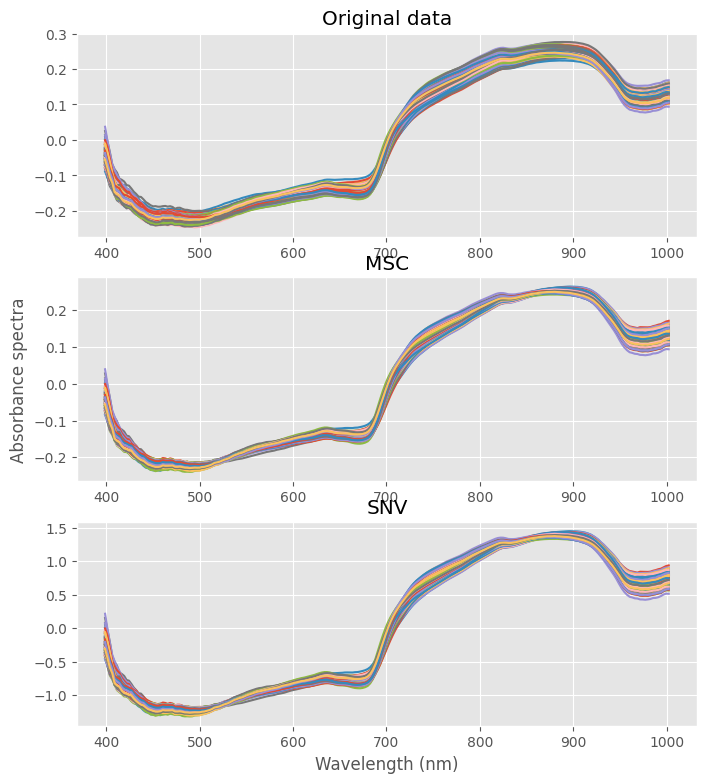

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
X = kiwi_spectra
 
Xmsc = msc(X)[0] # Take the first element of the output tuple
Xsnv = snv(X)
 
## Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(311)
    plt.plot(wl, X.T)
    plt.title('Original data')
 
    ax2 = plt.subplot(312)
    plt.plot(wl, Xmsc.T)
    plt.ylabel('Absorbance spectra')
    plt.title('MSC')
 
    ax2 = plt.subplot(313)
    plt.plot(wl, Xsnv.T)
    plt.xlabel('Wavelength (nm)')
    plt.title('SNV')
    plt.show()

It looks like shape is the same, but MSC is saving the original range

Derivative

Automated pre-processing (nippy)

## Data partition

Kennard-Stone partition

Duplex partition (some more coming)

## Spectral calibration

Principal component regression

PLSR 

Supervised outlier removal with PLS (& explain cross-validation)

Model diagnostics

Deep learning methods (simple convolution)